In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = [u'MNR', u'PVH', u'GSM', u'DSGX', u'ENTA']#, u'PSTG', u'MRVL', u'HOME']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
print(start)
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'yahoo', start)['Adj Close']
#     df[symbol] = data.DataReader(symbol, 'google', start)['Close']

2017-05-12
MNR
PVH
GSM
DSGX
ENTA
Wall time: 24.4 s


In [6]:
df.head()

,MNR,PVH,GSM,DSGX,ENTA
Date,,,,,
2017-05-12,13.676723,100.092514,8.60,23.650000,33.310001
2017-05-15,13.764896,100.392220,8.74,23.950001,32.820000
2017-05-16,13.735506,99.031029,8.78,24.400000,32.570000
2017-05-17,13.745302,97.412003,8.81,23.549999,32.060001
2017-05-18,14.166577,99.031029,9.01,23.400000,32.049999


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


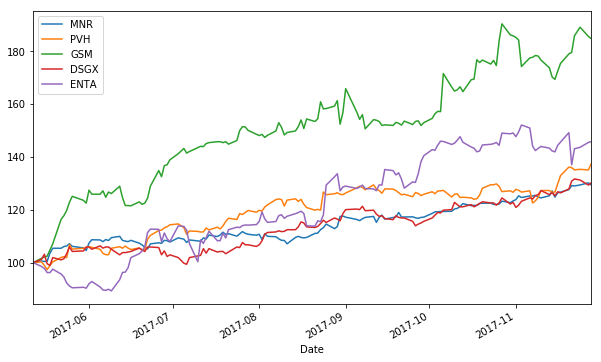

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
df

,MNR,PVH,GSM,DSGX,ENTA
Date,,,,,
2017-05-12,13.676723,100.092514,8.600000,23.650000,33.310001
2017-05-15,13.764896,100.392220,8.740000,23.950001,32.820000
2017-05-16,13.735506,99.031029,8.780000,24.400000,32.570000
2017-05-17,13.745302,97.412003,8.810000,23.549999,32.060001
2017-05-18,14.166577,99.031029,9.010000,23.400000,32.049999
2017-05-19,14.421301,100.350258,9.210000,24.100000,32.480000
2017-05-22,14.421301,102.059235,10.010000,23.900000,31.870001
2017-05-23,14.509475,102.319077,10.130000,24.000000,31.500000
2017-05-24,14.538866,101.979279,10.300000,24.450001,30.740000


In [10]:
rets.mean() * 252

MNR     0.470892
PVH     0.580632
GSM     1.122234
DSGX    0.482364
ENTA    0.689082
dtype: float64

In [11]:
rets.cov() * 252

,MNR,PVH,GSM,DSGX,ENTA
MNR,0.020501,0.002846,0.003388,0.003283,-0.000876
PVH,0.002846,0.037578,0.010494,0.007382,0.010140
GSM,0.003388,0.010494,0.111102,0.010311,0.008183
DSGX,0.003283,0.007382,0.010311,0.032331,0.001203
ENTA,-0.000876,0.010140,0.008183,0.001203,0.131397


In [12]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.22696122,  0.07036126,  0.25450707,  0.12240118,  0.32576927])

In [13]:
np.dot(weights.T, rets.mean()) * 252

0.71686832283326329

In [14]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.026465725135441102

In [15]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.16268289748907566

In [16]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

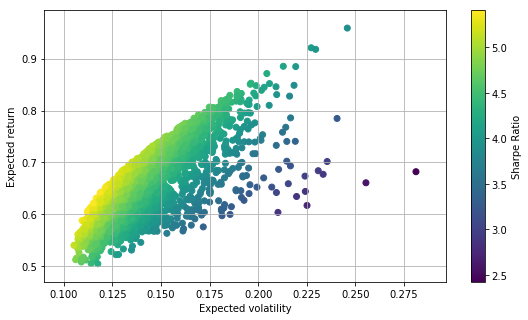

In [17]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [18]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [19]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [20]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [21]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 50 ms


In [22]:
opts

     fun: -5.453032134518193
     jac: array([-0.00107652, -0.00173211,  0.00343269, -0.00072485,  0.00401819])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.39843502,  0.18855042,  0.15642234,  0.17152248,  0.08506974])

In [23]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    out = zip(symbols, t * xs)
    out = sorted(out, key=lambda tup: tup[1], reverse=True)
    return out

In [29]:
out = calc_weights(424.00, opts.x, df)
print [(sym[0], round(sym[1],2)) for sym in out]
print [sym[0] for sym in out if sym[1] > 0.00001]

[(u'MNR', 3.76), (u'PVH', 1.78), (u'DSGX', 1.62), (u'GSM', 1.48), (u'ENTA', 0.8)]
[u'MNR', u'PVH', u'DSGX', u'GSM', u'ENTA']


In [25]:
df.tail(1)

,MNR,PVH,GSM,DSGX,ENTA
Date,,,,,
2017-11-28,17.700001,137.559998,15.9,30.799999,48.580002


In [26]:
450 - 2 * 108 - 2 * 57 - 4 * 22

32

In [27]:
# CRM-2, SQM-2, HPQ-4, ASYS-2